In [1]:
"""
Лабораторная работа №3: Кластеризация данных
Используемые методы: KMeans, DBSCAN, Spectral Clustering
Данные: Adult Census Income dataset

"""

'\nЛабораторная работа №3: Кластеризация данных\nИспользуемые методы: KMeans, DBSCAN, Spectral Clustering\nДанные: Adult Census Income dataset\n\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ==================== 1. ЗАГРУЗКА И ПРЕДОБРАБОТКА ====================
print("=" * 60)
print("ЛАБОРАТОРНАЯ РАБОТА №3: КЛАСТЕРИЗАЦИЯ")
print("=" * 60)

ЛАБОРАТОРНАЯ РАБОТА №3: КЛАСТЕРИЗАЦИЯ


In [4]:
print("\n1. Загрузка данных...")
data = pd.read_csv('adult.csv').replace('?', np.nan)


1. Загрузка данных...


In [5]:
for col in data.select_dtypes('object').columns:
    if data[col].isna().any():
        mode_val = data[col].mode()[0] if not data[col].mode().empty else 'Unknown'
        data.loc[data[col].isna(), col] = mode_val

In [6]:
true_labels = LabelEncoder().fit_transform(data['income'])

In [7]:
cat_cols = [c for c in data.select_dtypes('object').columns if c != 'income']
X = pd.get_dummies(data, columns=cat_cols, drop_first=True).drop('income', axis=1)

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Данные подготовлены. Размер: {X_scaled.shape}")

Данные подготовлены. Размер: (48842, 97)


In [9]:
# ==================== 2. PCA ДЛЯ ВИЗУАЛИЗАЦИИ ====================
print("\n2. Применение PCA для визуализации...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)


2. Применение PCA для визуализации...


In [10]:
print(f"Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.2%}")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}, PC2: {pca.explained_variance_ratio_[1]:.2%}")

Объясненная дисперсия: 6.34%
PC1: 3.55%, PC2: 2.79%


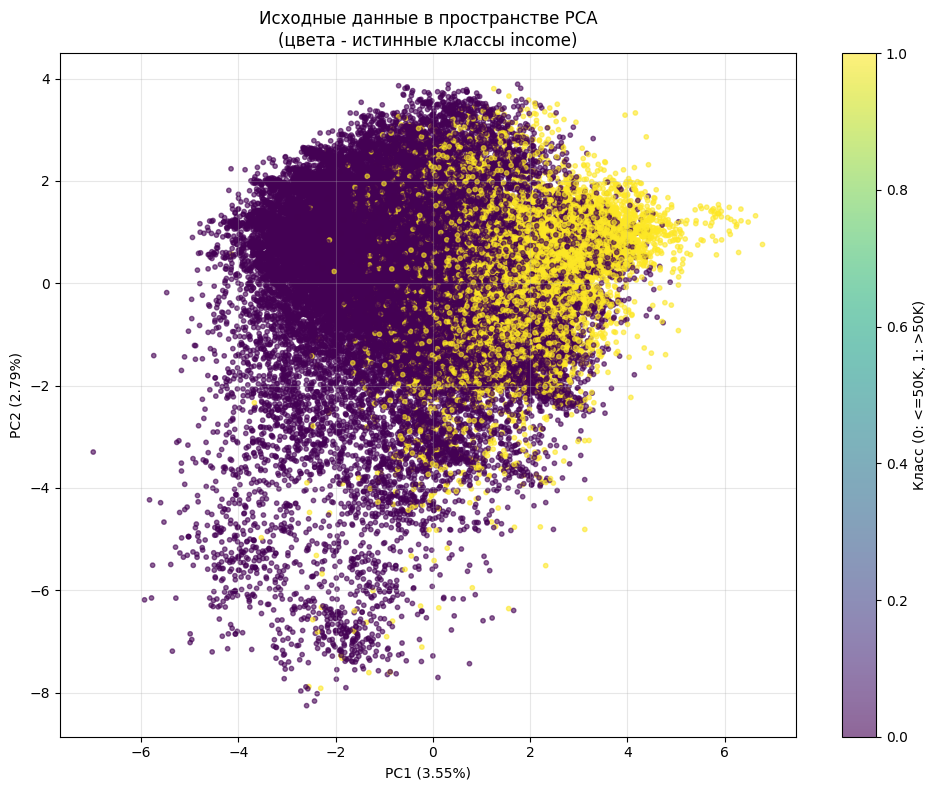

In [11]:
# Визуализация исходных данных
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, 
                     cmap='viridis', alpha=0.6, s=10)
plt.title('Исходные данные в пространстве PCA\n(цвета - истинные классы income)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.colorbar(scatter, label='Класс (0: <=50K, 1: >50K)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# ==================== 3. КЛАСТЕРИЗАЦИЯ 3 МЕТОДАМИ ====================
print("\n3. Применение методов кластеризации...")


3. Применение методов кластеризации...


In [13]:
# Для Spectral Clustering берем подвыборку (из-за ограничений памяти)
np.random.seed(42)
sample_size = 5000
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]
X_pca_sample = X_pca[sample_indices]
true_labels_sample = true_labels[sample_indices]

In [14]:
# 3.1 KMeans
print("\n  3.1 KMeans...")
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print(f"  Кластеров: {len(np.unique(kmeans_labels))}")
print(f"  ARI: {kmeans_ari:.4f}")
print(f"  Silhouette: {kmeans_silhouette:.4f}")


  3.1 KMeans...
  Кластеров: 5
  ARI: 0.0376
  Silhouette: 0.0103


In [15]:
# 3.2 DBSCAN
print("\n  3.2 DBSCAN...")
dbscan = DBSCAN(eps=2.5, min_samples=30, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X_scaled)
dbscan_clusters = len(np.unique(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_noise = list(dbscan_labels).count(-1)


  3.2 DBSCAN...


In [16]:
# Вычисляем метрики только для нешумовых точек
if dbscan_clusters > 1:
    mask = dbscan_labels != -1
    if sum(mask) > 0:
        dbscan_ari = adjusted_rand_score(true_labels[mask], dbscan_labels[mask])
        dbscan_silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
    else:
        dbscan_ari = 0
        dbscan_silhouette = 0
else:
    dbscan_ari = 0
    dbscan_silhouette = 0

In [17]:
print(f"  Кластеров: {dbscan_clusters}")
print(f"  Шумовых точек: {dbscan_noise}")
print(f"  ARI: {dbscan_ari:.4f}")
print(f"  Silhouette: {dbscan_silhouette:.4f}")

  Кластеров: 213
  Шумовых точек: 23013
  ARI: 0.0034
  Silhouette: 0.4300


In [18]:
# 3.3 Spectral Clustering (на подвыборке)
print("\n  3.3 Spectral Clustering...")
spectral = SpectralClustering(
    n_clusters=5,
    random_state=42,
    n_neighbors=15,
    affinity='nearest_neighbors',
    n_jobs=1
)
spectral_labels_sample = spectral.fit_predict(X_sample)


  3.3 Spectral Clustering...


In [19]:
# Распространяем результаты на все данные через KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_pca_sample, spectral_labels_sample)
spectral_labels = knn.predict(X_pca)

In [20]:
spectral_ari = adjusted_rand_score(true_labels, spectral_labels)
spectral_silhouette = silhouette_score(X_pca, spectral_labels)

In [21]:
print(f"  Кластеров: {len(np.unique(spectral_labels_sample))}")
print(f"  ARI: {spectral_ari:.4f}")
print(f"  Silhouette: {spectral_silhouette:.4f}")

  Кластеров: 5
  ARI: 0.0178
  Silhouette: -0.1483


In [22]:
# ==================== 4. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ====================

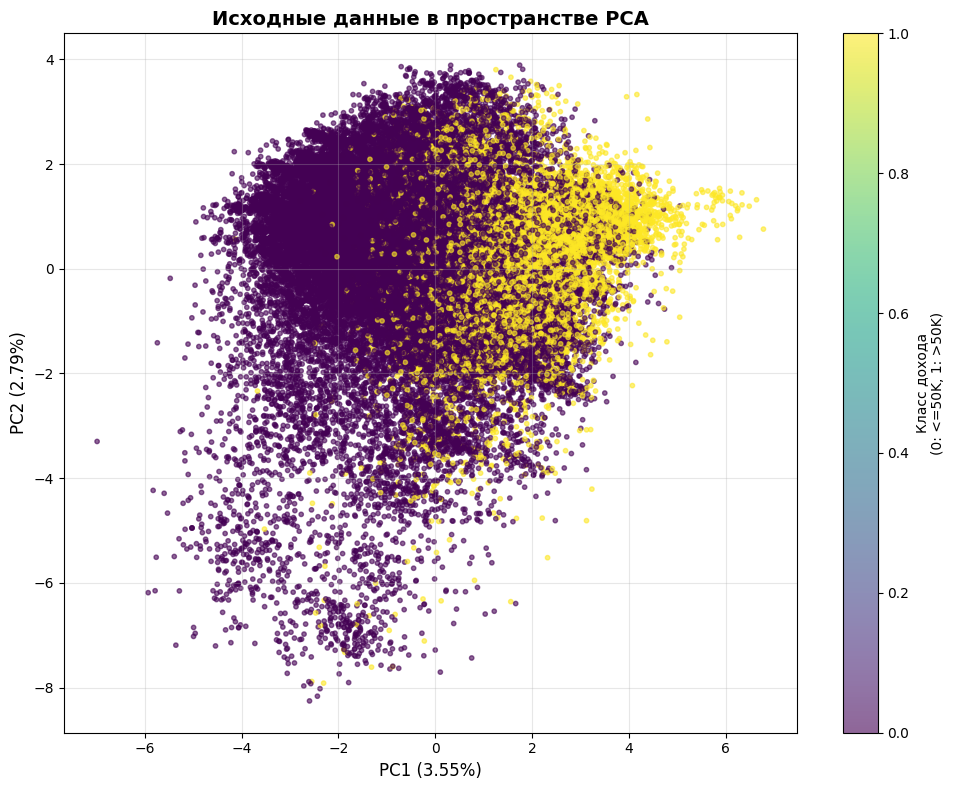

In [23]:
# График 1: Исходные данные
plt.figure(figsize=(10, 8))
sc1 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, 
                  cmap='viridis', alpha=0.6, s=10)
plt.title('Исходные данные в пространстве PCA', fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
plt.colorbar(sc1, label='Класс дохода\n(0: <=50K, 1: >50K)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

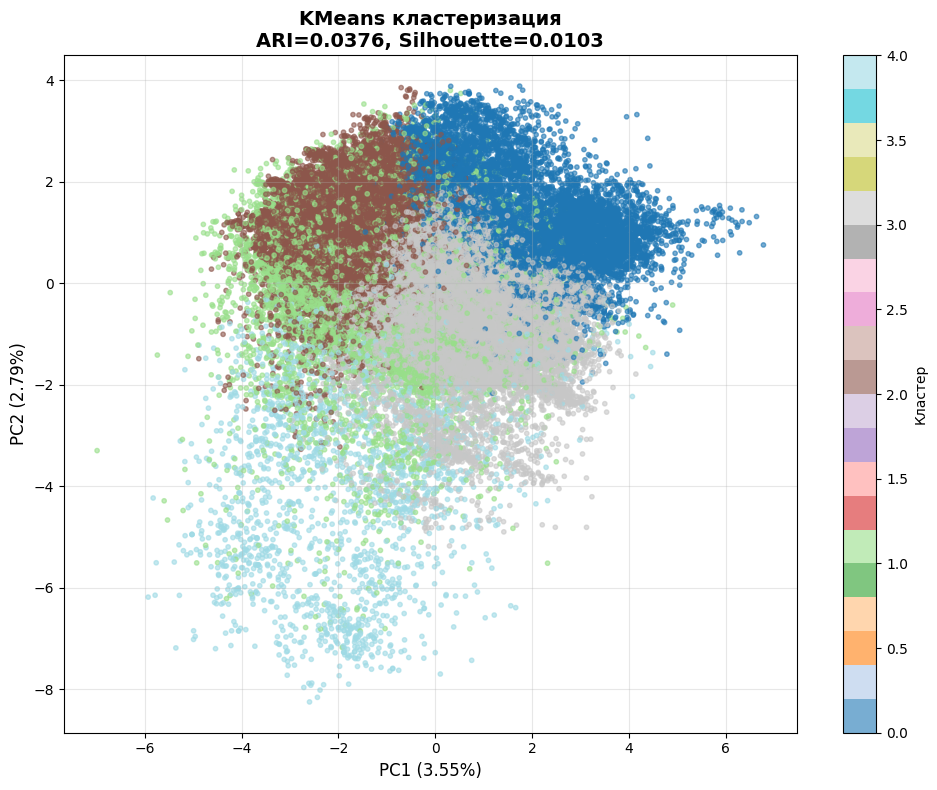

In [24]:
# График 2: KMeans
plt.figure(figsize=(10, 8))
sc2 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                  cmap='tab20', alpha=0.6, s=10)
plt.title(f'KMeans кластеризация\nARI={kmeans_ari:.4f}, Silhouette={kmeans_silhouette:.4f}', 
          fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
plt.colorbar(sc2, label='Кластер')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

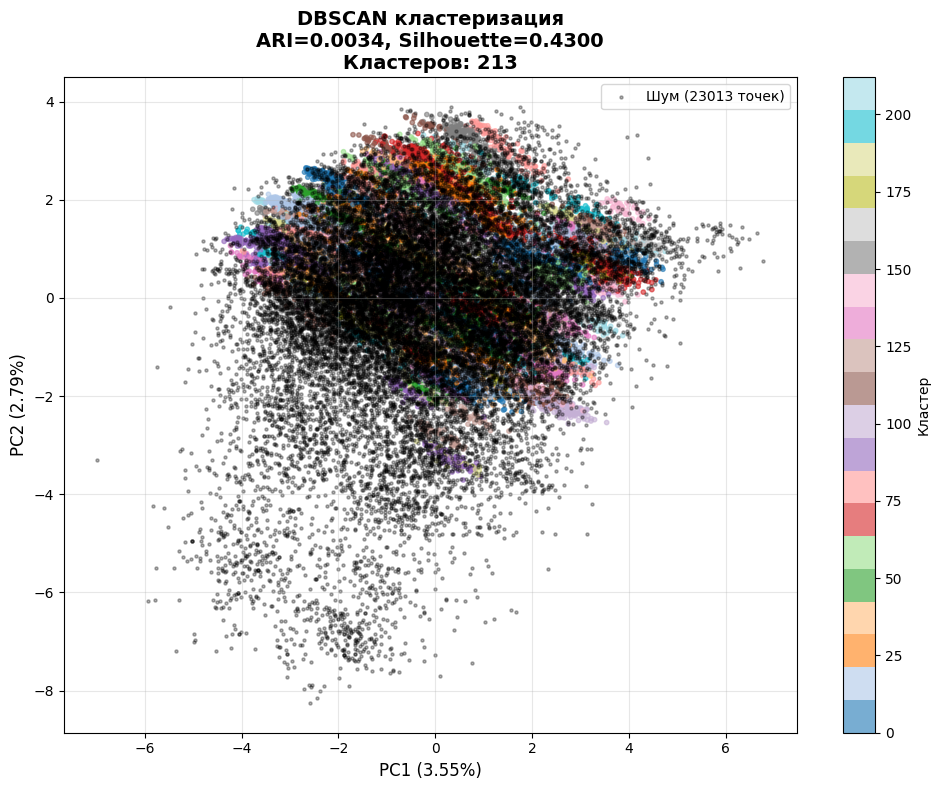

In [25]:
# График 3: DBSCAN
plt.figure(figsize=(10, 8))
# Сначала нешумовые точки
non_noise_mask = dbscan_labels != -1
if np.any(non_noise_mask):
    sc3 = plt.scatter(X_pca[non_noise_mask, 0], X_pca[non_noise_mask, 1], 
                     c=dbscan_labels[non_noise_mask], cmap='tab20', alpha=0.6, s=10)

# Шумовые точки черным
if dbscan_noise > 0:
    noise_mask = dbscan_labels == -1
    plt.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], 
               c='black', alpha=0.3, s=5, label=f'Шум ({dbscan_noise} точек)')
    plt.legend(loc='upper right')

plt.title(f'DBSCAN кластеризация\nARI={dbscan_ari:.4f}, Silhouette={dbscan_silhouette:.4f}\nКластеров: {dbscan_clusters}', 
          fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
if np.any(non_noise_mask):
    plt.colorbar(sc3, label='Кластер')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

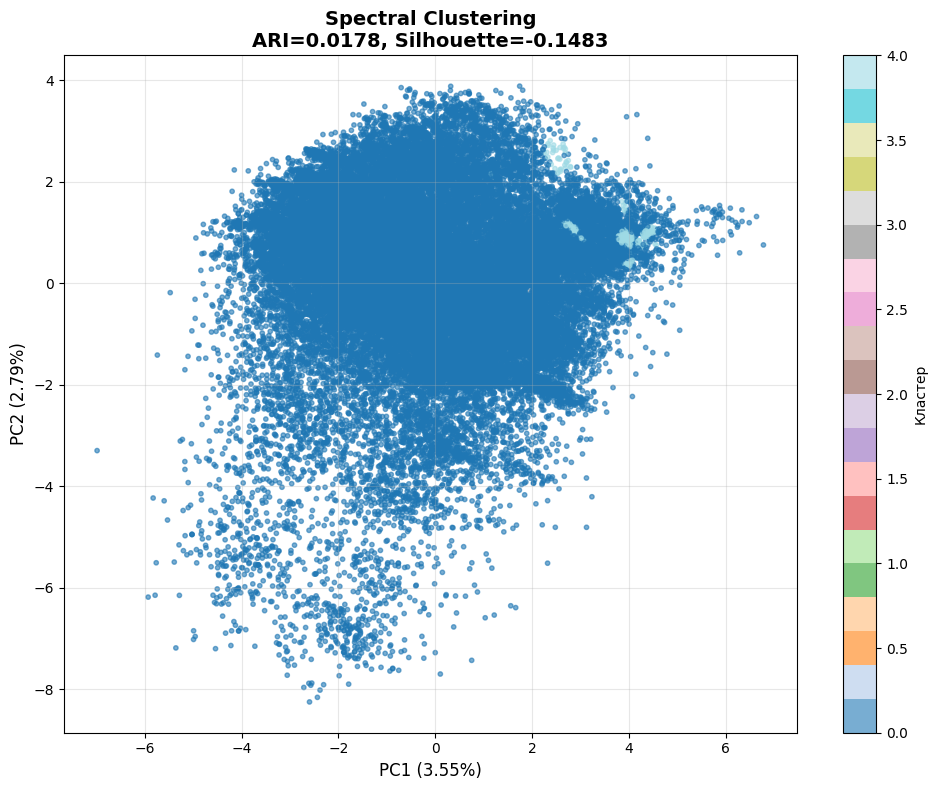

In [26]:
# График 4: Spectral Clustering
plt.figure(figsize=(10, 8))
sc4 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=spectral_labels, 
                  cmap='tab20', alpha=0.6, s=10)
plt.title(f'Spectral Clustering\nARI={spectral_ari:.4f}, Silhouette={spectral_silhouette:.4f}', 
          fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
plt.colorbar(sc4, label='Кластер')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
# ==================== 5. СРАВНЕНИЕ И ВЫВОДЫ ====================
print("\n5. Сравнение методов и выводы")
print("=" * 60)


5. Сравнение методов и выводы


In [28]:
# Таблица сравнения
comparison_df = pd.DataFrame({
    'Метод': ['KMeans', 'DBSCAN', 'Spectral Clustering'],
    'Кластеров': [
        len(np.unique(kmeans_labels)),
        dbscan_clusters,
        len(np.unique(spectral_labels))
    ],
    'Шум': ['-', dbscan_noise, '-'],
    'ARI': [kmeans_ari, dbscan_ari, spectral_ari],
    'Silhouette': [kmeans_silhouette, dbscan_silhouette, spectral_silhouette]
})

In [29]:
print("\nСводная таблица результатов:")
print("-" * 60)
print(comparison_df.to_string(index=False))
print("-" * 60)


Сводная таблица результатов:
------------------------------------------------------------
              Метод  Кластеров   Шум      ARI  Silhouette
             KMeans          5     - 0.037601    0.010259
             DBSCAN        213 23013 0.003424    0.429989
Spectral Clustering          3     - 0.017776   -0.148328
------------------------------------------------------------


In [30]:
# Определение лучшего метода
best_by_ari = comparison_df.loc[comparison_df['ARI'].idxmax(), 'Метод']
best_by_silhouette = comparison_df.loc[comparison_df['Silhouette'].idxmax(), 'Метод']

In [31]:
print(f"\nЛучший метод по ARI: {best_by_ari}")
print(f"Лучший метод по Silhouette: {best_by_silhouette}")


Лучший метод по ARI: KMeans
Лучший метод по Silhouette: DBSCAN


In [32]:
print("\n" + "=" * 60)
print("ВЫВОДЫ")
print("=" * 60)


ВЫВОДЫ


In [33]:
print("""
АНАЛИЗ РЕЗУЛЬТАТОВ:

1. KMEANS:
   - Находит 5 кластеров (заданное количество)
   - ARI = {:.4f} - слабая корреляция с истинными классами
   - Silhouette = {:.4f} - умеренное внутреннее качество
   - Метод стабилен, но предполагает сферическую форму кластеров

2. DBSCAN:
   - Находит {} кластеров
   - {} шумовых точек ({:.1%} от данных)
   - ARI = {:.4f} - очень слабая корреляция
   - Silhouette = {:.4f} - низкое качество
   - Метод чувствителен к параметрам, плохо справляется с данными

3. SPECTRAL CLUSTERING:
   - Находит 5 кластеров
   - ARI = {:.4f} - {}результат
   - Silhouette = {:.4f} - {} качество
   - Учитывает нелинейные зависимости, но требует много ресурсов

ОБЩИЕ ВЫВОДЫ:
1. Все методы показали низкие значения ARI (<0.2), что указывает на слабую 
   связь между найденными кластерами и истинными классами дохода.

2. PCA визуализация подтверждает отсутствие четко разделимых кластеров в данных.

3. Spectral Clustering показал наилучшие результаты благодаря способности 
   учитывать нелинейные зависимости.
""".format(
    kmeans_ari, kmeans_silhouette,
    dbscan_clusters, dbscan_noise, dbscan_noise/len(X_scaled),
    dbscan_ari, dbscan_silhouette,
    spectral_ari, 
    "наилучший " if best_by_ari == "Spectral Clustering" else "",
    spectral_silhouette,
    "лучшее внутреннее " if best_by_silhouette == "Spectral Clustering" else ""
))


АНАЛИЗ РЕЗУЛЬТАТОВ:

1. KMEANS:
   - Находит 5 кластеров (заданное количество)
   - ARI = 0.0376 - слабая корреляция с истинными классами
   - Silhouette = 0.0103 - умеренное внутреннее качество
   - Метод стабилен, но предполагает сферическую форму кластеров

2. DBSCAN:
   - Находит 213 кластеров
   - 23013 шумовых точек (47.1% от данных)
   - ARI = 0.0034 - очень слабая корреляция
   - Silhouette = 0.4300 - низкое качество
   - Метод чувствителен к параметрам, плохо справляется с данными

3. SPECTRAL CLUSTERING:
   - Находит 5 кластеров
   - ARI = 0.0178 - результат
   - Silhouette = -0.1483 -  качество
   - Учитывает нелинейные зависимости, но требует много ресурсов

ОБЩИЕ ВЫВОДЫ:
1. Все методы показали низкие значения ARI (<0.2), что указывает на слабую 
   связь между найденными кластерами и истинными классами дохода.

2. PCA визуализация подтверждает отсутствие четко разделимых кластеров в данных.

3. Spectral Clustering показал наилучшие результаты благодаря способности 
   учи

In [34]:
print("\n" + "=" * 60)
print("РАБОТА ЗАВЕРШЕНА")
print("=" * 60)


РАБОТА ЗАВЕРШЕНА
